In [4]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import pathlib
import PIL 
import numpy as np
import os
import plotly.graph_objects as go
import seaborn as sns
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from random import sample

import warnings

warnings.filterwarnings('ignore')

In [5]:
data_dir = image_dataset_from_directory(
    '../cacao_photos/',
    label_mode='int')


Found 2829 files belonging to 3 classes.


In [6]:
class_names = data_dir.class_names

def count_data_per_class() -> None:
    for class_name in class_names:
        print(class_name, ":", len(os.listdir("../cacao_photos/"+class_name)))

def get_class_count(class_name:str) -> int:

    if class_name in class_names:
        return len(os.listdir("../cacao_photos/"+class_name))
    else:
        return 0

count_data_per_class()
get_class_count('black_pod_rot')

black_pod_rot : 943
healthy : 943
pod_borer : 943


943

In [7]:
count_data_per_class()

black_pod_rot : 943
healthy : 943
pod_borer : 943


In [8]:

batch_size = 1
img_height = 224
img_width = 224
epochs = 30

In [9]:
train_dataset = image_dataset_from_directory(
    '../cacao_photos/',
    validation_split = 0.2,
    labels='inferred',
    subset = 'training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size= batch_size
)

Found 2829 files belonging to 3 classes.
Using 2264 files for training.


In [10]:
validation_dataset = image_dataset_from_directory(
    '../cacao_photos/',
    validation_split = 0.2,
    labels='inferred',
    subset = 'validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size= batch_size
)

Found 2829 files belonging to 3 classes.
Using 565 files for validation.


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
from tensorflow.keras.applications import EfficientNetV2B0

In [15]:
num_classes = len(class_names)

pretrained_model = EfficientNetV2B0(include_top=False, input_shape=(img_height, img_width, 3))
pretrained_model.trainable = False
for layer in pretrained_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model = Sequential([
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  mode='min',
                                                  patience=4)

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 5,923,155
Trainable params: 3,843
Non-trainable params: 5,919,312
_________________________________________________________________


In [16]:
from tensorflow.keras.callbacks import TensorBoard

file_name = 'results_EfficientNetV2B0_RMSprop'

tensorboard = TensorBoard(log_dir="../logs\\{}".format(file_name))

In [17]:
model_history = model.fit(train_dataset,
                                  epochs=epochs,
                                  callbacks = [ early_stopping, tensorboard],
                                  validation_data=validation_dataset)

Epoch 1/30
2264/2264 [==============================] - 451s 185ms/step - loss: 0.4598 - accuracy: 0.8114 - val_loss: 0.2971 - val_accuracy: 0.8761
Epoch 2/30
2264/2264 [==============================] - 395s 175ms/step - loss: 0.3156 - accuracy: 0.8732 - val_loss: 0.2648 - val_accuracy: 0.8903
Epoch 3/30
2264/2264 [==============================] - 351s 155ms/step - loss: 0.2811 - accuracy: 0.8891 - val_loss: 0.2720 - val_accuracy: 0.9044
Epoch 4/30
2264/2264 [==============================] - 350s 155ms/step - loss: 0.2668 - accuracy: 0.9050 - val_loss: 0.2593 - val_accuracy: 0.8973
Epoch 5/30
2264/2264 [==============================] - 374s 165ms/step - loss: 0.2467 - accuracy: 0.9086 - val_loss: 0.2949 - val_accuracy: 0.8938
Epoch 6/30
2264/2264 [==============================] - 385s 170ms/step - loss: 0.2609 - accuracy: 0.9064 - val_loss: 0.2369 - val_accuracy: 0.9168
Epoch 7/30
2264/2264 [==============================] - 394s 174ms/step - loss: 0.2297 - accuracy: 0.9139 - val_

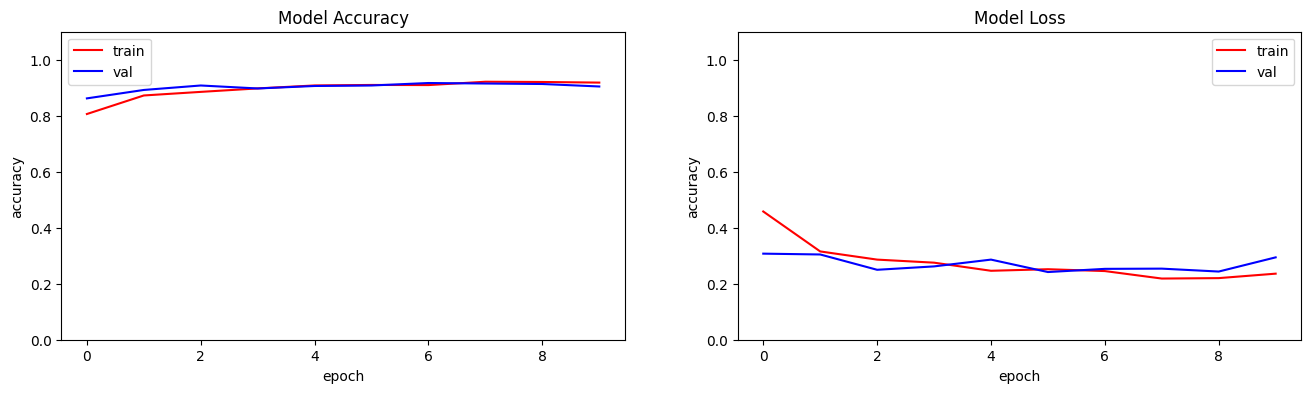

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'], color="red")
plt.plot(model_history.history['val_accuracy'], color="blue")
plt.title('Model Accuracy')
plt.ylim(top=1.1)
plt.ylim(bottom=0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], color="red")
plt.plot(model_history.history['val_loss'], color="blue")
plt.title('Model Loss')
plt.ylim(top=1.1)
plt.ylim(bottom=0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [ ]:

def display_training_curves(training, validation, yaxis):
    if yaxis == "loss":
        ylabel = "Loss"
        title = "Loss with respect to Epochs"
    else:
        ylabel = "Accuracy"
        title = "Accuracy with respect to Epochs"
        
    fig = go.Figure()
        
    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=training, marker=dict(color="dodgerblue"),
               name="Training"))
    
    fig.add_trace(
        go.Scatter(x=np.arange(1, epochs+1), mode='lines+markers', y=validation, marker=dict(color="darkorange"),
               name="Validation"))
    
    fig.update_layout(title_text=title, yaxis_title=ylabel, xaxis_title="Epochs", template="plotly_white")
    fig.show()



In [ ]:
display_training_curves(
    model_history.history['accuracy'], 
    model_history.history['val_accuracy'], 
    'accuracy')

In [ ]:
display_training_curves(
    model_history.history['loss'], 
    model_history.history['val_loss'], 
    'validation')

In [ ]:
val_pred = model.predict(validation_dataset)

565/565 [==============================] - 31s 40ms/step


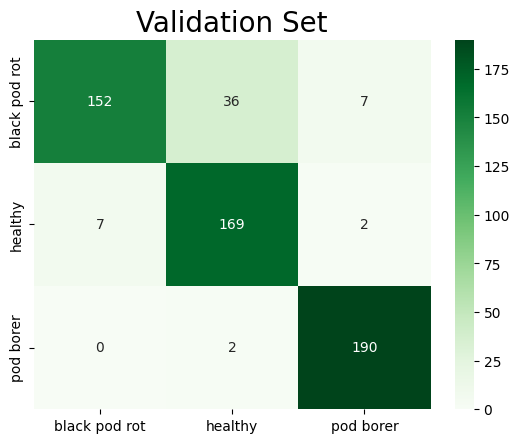

In [ ]:


labels = []
preds = []
for _, label in validation_dataset.as_numpy_iterator():
    for i in label:
        labels.append(i)

for pred in val_pred:
    pred_list = pred.tolist()
    preds.append(pred_list.index(max(pred_list)))

val_cm = confusion_matrix(labels, preds, labels=[0,1,2],)
val_axis_labels = ['black pod rot', 'healthy', 'pod borer']
plt.title("Validation Set", fontsize =20)
val_ax = sns.heatmap(val_cm,
                 cmap="Greens",
                 annot=True,
                 xticklabels=val_axis_labels,
                 yticklabels=val_axis_labels,
                 fmt="d")

In [ ]:
print(classification_report(labels, preds, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86       195
           1       0.82      0.95      0.88       178
           2       0.95      0.99      0.97       192

    accuracy                           0.90       565
   macro avg       0.91      0.91      0.90       565
weighted avg       0.91      0.90      0.90       565



In [19]:
efficientNetB0 = {
    'loss' : [0.4248, 0.2864, 0.2321, 0.2357, 0.2202, 0.2264, 0.2157, 0.2172, 0.2033],
    'accuracy': [0.8140, 0.8865, 0.9099, 0.9090, 0.9214, 0.9236, 0.9205, 0.9258, 0.9271],
    'val_loss': [0.2743, 0.2719, 0.2671, 0.2812, 0.2605, 0.2607, 0.2866, 0.2819, 0.2875],
    'val_accuracy': [0.8938, 0.8920, 0.8956, 0.8903, 0.9062, 0.9133, 0.9080, 0.9062, 0.9097]
}

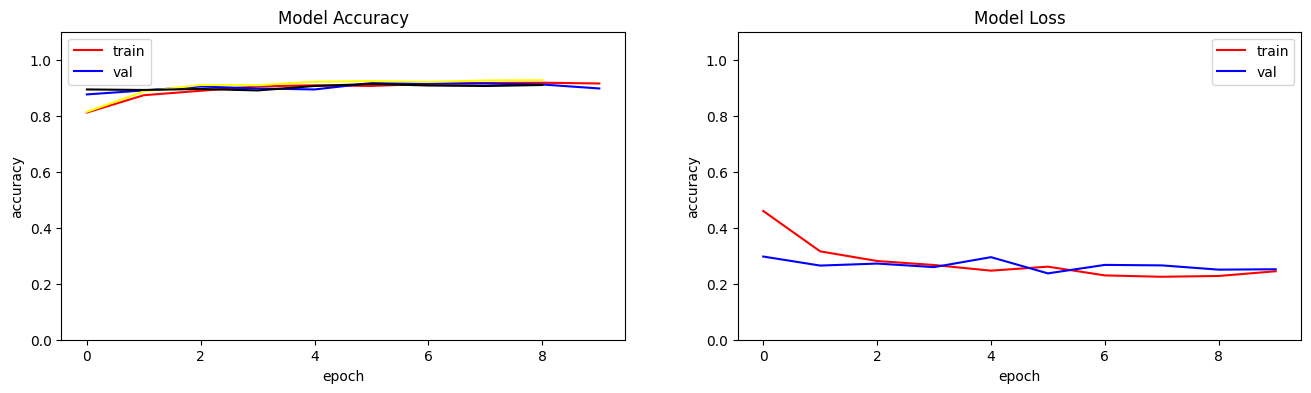

In [20]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'], color="red")
plt.plot(model_history.history['val_accuracy'], color="blue")


plt.plot(efficientNetB0['accuracy'], color="yellow")
plt.plot(efficientNetB0['val_accuracy'], color="black")
plt.title('Model Accuracy')
plt.ylim(top=1.1)
plt.ylim(bottom=0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], color="red")
plt.plot(model_history.history['val_loss'], color="blue")


plt.plot(efficientNetB0['loss'], color="yellow")
plt.plot(efficientNetB0['val_loss'], color="black")
plt.title('Model Loss')
plt.ylim(top=1.1)
plt.ylim(bottom=0)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()